In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load data and convert dateRep from object to datetime format
def load_data():
    path = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'
    ts = pd.read_csv(path)
    ts['dateRep'] = pd.to_datetime(ts['dateRep'], dayfirst=True)
    
    return ts

In [3]:
#Pivot data to get the sum of cases and deaths
def pivot_data(ts):
    ts_pivot = pd.pivot_table(ts, index='dateRep', values=['cases', 'deaths'], aggfunc='sum')
    return ts_pivot

In [4]:
#Shift column by specified range
def add_shift(ts, col, shiftrange):
    new_col = col + '_shift' + str(shiftrange)
    ts[new_col] = ts[col].shift(shiftrange)
    
    return ts

In [5]:
#Use log to transform data
def fix_skewed_data(ts, col):
    ts[col] = np.log(ts[col])
    
    return ts

In [6]:
#Scale target using the standard scaler
def scale_targets(y_train, y_test, col):
    sc = StandardScaler()
    y_train['target'] = sc.fit_transform(y_train[[col]])
    y_test['target'] = sc.transform(y_test[[col]])
    
    return sc, y_train, y_test

In [7]:
#Scale list of features using the standard scaler
def scale_features(X_train, X_test, col_list):
    for col in col_list:
        sc = StandardScaler()
        X_train[col] = sc.fit_transform(X_train[[col]])
        X_test[col] = sc.transform(X_test[[col]])
        
    return X_train, X_test

In [8]:
#Get the year, week and weekday information from the datetime index
def add_isodate(ts):
    ts[['year', 'week', 'weekday']] = pd.DataFrame(
        ts.index.map(lambda x: x.isocalendar()).tolist(), index=ts.index)
    
    return ts

In [9]:
#Get the month information from the datetime index
def add_month(ts):
    ts['month'] = ts.index.month
    
    return ts

In [10]:
#Calculate the mape
def calculate_mape(y, y_hat):
    perc_err = (100 * (y - y_hat)) / y
    
    return pd.np.mean(abs(perc_err))

In [57]:
#Create two plots showing the target, prediction and error
def plot_error(ts, target):
    ts['error'] = ts['prediction'] - ts[target]
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
    ts[[target, 'prediction']].plot(ax=axes[0])
    ts['error'].plot(ax=axes[1])

In [12]:
df = load_data()
df = pivot_data(df)

#Show correlations for shifted cases and deaths
for i in range(1,15):
    df = add_shift(df, 'cases', i)
df.corr()

,cases,deaths,cases_shift1,cases_shift2,cases_shift3,cases_shift4,cases_shift5,cases_shift6,cases_shift7,cases_shift8,cases_shift9,cases_shift10,cases_shift11,cases_shift12,cases_shift13,cases_shift14
cases,1.000000,0.910636,0.988680,0.979300,0.971781,0.970845,0.972943,0.973782,0.969901,0.960387,0.947243,0.936338,0.929334,0.923610,0.919573,0.913313
deaths,0.910636,1.000000,0.891103,0.881266,0.882616,0.892006,0.903888,0.913943,0.909833,0.886042,0.866610,0.858993,0.864406,0.863478,0.862832,0.844672
cases_shift1,0.988680,0.891103,1.000000,0.988590,0.978986,0.971456,0.970815,0.973152,0.973581,0.969519,0.959799,0.946602,0.935436,0.928499,0.922666,0.918347
cases_shift2,0.979300,0.881266,0.988590,1.000000,0.988513,0.979094,0.971926,0.971544,0.973318,0.973555,0.969180,0.959314,0.946265,0.935262,0.928203,0.921779
cases_shift3,0.971781,0.882616,0.978986,0.988513,1.000000,0.988457,0.979185,0.972066,0.971273,0.972972,0.973159,0.968843,0.958785,0.945711,0.934496,0.927094
cases_shift4,0.970845,0.892006,0.971456,0.979094,0.988457,1.000000,0.988309,0.978921,0.971505,0.970718,0.972674,0.973187,0.968224,0.957985,0.944629,0.933347
cases_shift5,0.972943,0.903888,0.970815,0.971926,0.979185,0.988309,1.000000,0.988033,0.978490,0.971037,0.970695,0.973188,0.972679,0.967468,0.956987,0.943798
cases_shift6,0.973782,0.913943,0.973152,0.971544,0.972066,0.978921,0.988033,1.000000,0.987876,0.978276,0.971214,0.971442,0.972754,0.972029,0.966692,0.956539
cases_shift7,0.969901,0.909833,0.973581,0.973318,0.971273,0.971505,0.978490,0.987876,1.000000,0.987659,0.978156,0.971352,0.970858,0.972182,0.971442,0.966167
cases_shift8,0.960387,0.886042,0.969519,0.973555,0.972972,0.970718,0.971037,0.978276,0.987659,1.000000,0.987576,0.978199,0.970801,0.970367,0.971719,0.970956


51.88727730676918


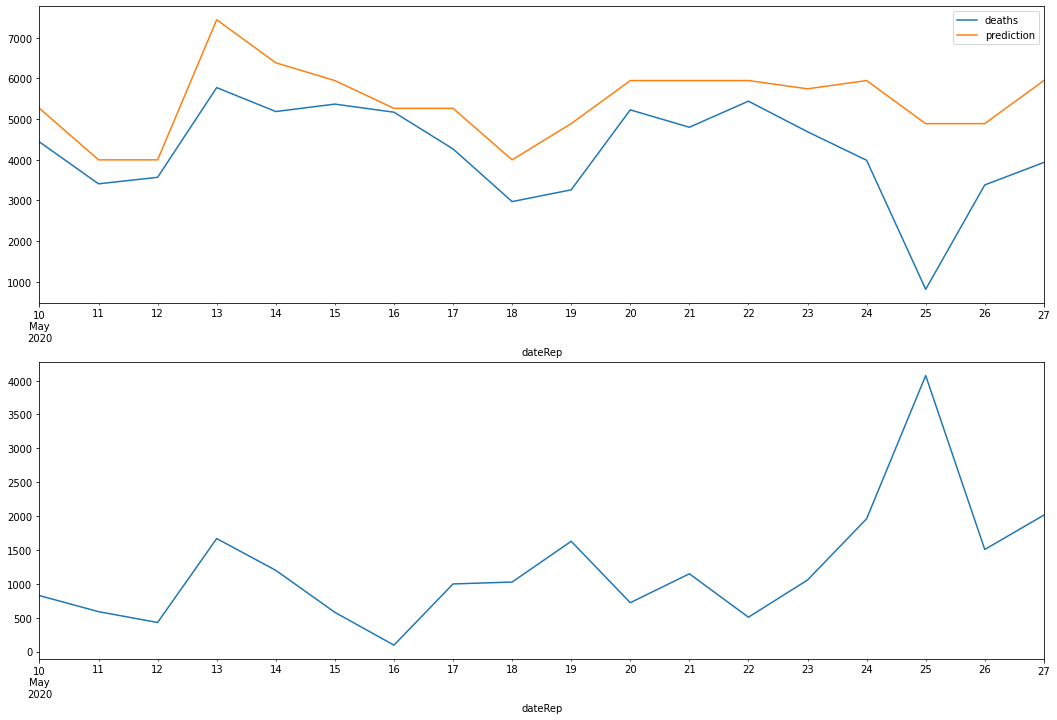

In [80]:
#Global deaths prediction
from sklearn.tree import DecisionTreeRegressor

df = load_data()
df = pivot_data(df)
#Get all shifts from 1 to 8 because these show the highest correlations withs deaths
for i in [1, 2, 3, 4, 5, 6, 7, 8]:
    df = add_shift(df, 'cases', i)

#Drop all day up to February because these contain 0s which will screw up the log function
drop_dates = pd.date_range(start='2019-12-31', end='2020-01-31', freq='D')
df = df[~df.index.isin(drop_dates)]

df = add_isodate(df)
df = add_month(df)

df = fix_skewed_data(df, 'deaths')

X = df.loc[:, ['year', 'month', 'week', 'weekday', 'cases_shift1', 'cases_shift2', 'cases_shift3', 'cases_shift4', 'cases_shift5', 'cases_shift6', 'cases_shift7', 'cases_shift8']]
y = df.loc[:, ['deaths']]

#Define the time range which we want to predict
end = X.index.max()
start = end - pd.Timedelta(17, unit='D')
X_train = X[(X.index < start) | (X.index > end)]
X_test = X[(X.index >= start) & (X.index <= end)]
y_train = y[(y.index < start) | (y.index > end)]
y_test = y[(y.index >= start) & (y.index <= end)]

sc, y_train, y_test = scale_targets(y_train, y_test, 'deaths')
X_train, X_test = scale_features(X_train, X_test, ['cases_shift1', 'cases_shift2', 'cases_shift3', 'cases_shift4', 'cases_shift5', 'cases_shift6', 'cases_shift7', 'cases_shift8'])

reg = DecisionTreeRegressor()
reg.fit(X_train, y_train.loc[:, y_train.columns == 'target'])

y_test['prediction_sc'] = reg.predict(X_test)
y_test['prediction'] = sc.inverse_transform(y_test[['prediction_sc']])

y_test['deaths'] = np.exp(y_test.deaths)
y_test['prediction'] = np.exp(y_test.prediction)

mape = calculate_mape(y_test.deaths, y_test.prediction)
print(mape)

plot_error(y_test, 'deaths')

6.9512781553869125 {'criterion': 'mse', 'splitter': 'best'}


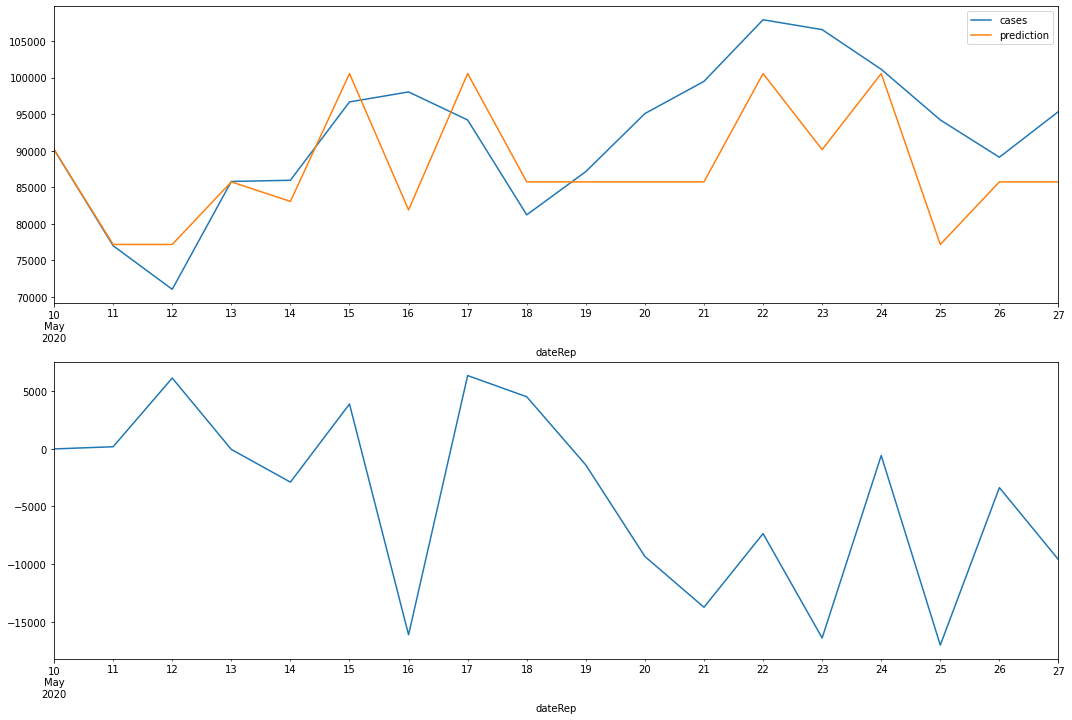

In [72]:
#Global cases prediction
from sklearn.tree import DecisionTreeRegressor

df = load_data()
df = pivot_data(df)
#Get all shifts from 1 to 8 because these show the highest correlations withs deaths
for i in range(1,15):
    df = add_shift(df, 'cases', i)

#Drop all day up to February because these contain 0s which will screw up the log function
drop_dates = pd.date_range(start='2019-12-31', end='2020-01-31', freq='D')
df = df[~df.index.isin(drop_dates)]
df.drop(columns='deaths', inplace=True)

df = add_isodate(df)
df = add_month(df)

df = fix_skewed_data(df, 'cases')

X = df.loc[:, df.columns != 'cases']
y = df.loc[:, ['cases']]

#Define the time range which we want to predict
end = X.index.max()
start = end - pd.Timedelta(17, unit='D')
X_train = X[(X.index < start) | (X.index > end)]
X_test = X[(X.index >= start) & (X.index <= end)]
y_train = y[(y.index < start) | (y.index > end)]
y_test = y[(y.index >= start) & (y.index <= end)]
sc, y_train, y_test = scale_targets(y_train, y_test, 'cases')
X_train, X_test = scale_features(X_train, X_test, ['cases_shift1', 'cases_shift2', 'cases_shift3', 'cases_shift4', 'cases_shift5',
                                                    'cases_shift6', 'cases_shift7', 'cases_shift8', 'cases_shift9', 'cases_shift10',
                                                    'cases_shift11', 'cases_shift12', 'cases_shift13', 'cases_shift14'])


params = {'criterion': ['mse', 'friedman-mse', 'mae'], 'splitter': ['best', 'random']}
reg = GridSearchCV(DecisionTreeRegressor(), params, cv=10)
reg.fit(X_train, y_train.loc[:, y_train.columns == 'target'])

y_test['prediction_sc'] = reg.predict(X_test)
y_test['prediction'] = sc.inverse_transform(y_test[['prediction_sc']])

y_test['cases'] = np.exp(y_test.cases)
y_test['prediction'] = np.exp(y_test.prediction)

mape = calculate_mape(y_test.cases, y_test.prediction)
print(mape, reg.best_params_)

plot_error(y_test, 'cases')

